In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import os
import csv
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score
import time as timer
from sklearn.inspection import permutation_importance
import itertools
import seaborn as sns
from sklearn.svm import LinearSVC,SVC
from sklearn.multiclass import OneVsRestClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LassoCV,LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier
from sklearn.feature_selection import chi2,SelectKBest,SelectFromModel,RFE,VarianceThreshold
from sklearn.metrics import confusion_matrix,precision_recall_curve,average_precision_score,roc_curve,auc,f1_score,accuracy_score,\
classification_report,multilabel_confusion_matrix, roc_auc_score,precision_recall_fscore_support
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,LabelEncoder,LabelBinarizer
from scipy import interp
from itertools import cycle
plt.style.use('ggplot');
import sys
if ("/your/path/to/xelatex") not in sys.path:
    print('adding path') # I just add this to know if the path was present or not.
    sys.path.append("/your/path/to/xelatex")

adding path


In [5]:
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE

In [6]:
data = pd.read_csv('data_adverse_imputed.csv')
data

,Residence,Mother_education,Sex_of_HH,mobile_phone,deliver_by_CS,Smoke,Distance_to_HF,Working_status,sex_of_child,Age_of_mother,...,Iron_supplementation,Type_of_pregnancy,ANC_visits,Birth_interval,Wanted_pregnancy,First_ANC_check,Place_of_delivery,Media_exposure,Regions,adverse_birth_outcome
0,2,0,1,0,1,0,1,1,1,4,...,0,0,0,1,1,0,1,0,1,0
1,1,1,2,0,0,0,1,1,1,2,...,0,0,2,1,1,1,1,0,1,1
2,1,0,2,0,0,0,1,0,2,3,...,0,0,2,1,1,1,1,0,1,1
3,1,0,2,0,0,0,1,0,1,3,...,0,0,1,0,1,0,0,0,1,1
4,1,1,2,0,0,0,1,1,1,3,...,1,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139654,2,2,1,0,0,0,1,0,1,1,...,1,0,2,1,1,1,1,0,3,0
139655,2,1,1,0,0,0,1,0,2,3,...,1,0,2,2,1,0,0,1,3,0
139656,2,2,1,1,0,0,1,1,1,3,...,1,0,1,2,1,0,1,1,3,0
139657,2,1,2,1,0,0,1,1,2,2,...,1,0,2,1,1,1,1,1,3,0


In [7]:
# "data" is the DataFrame
data.drop('Smoke', axis=1, inplace=True)
data.drop('Number_of_children', axis=1, inplace=True)

In [9]:
##Data Preprocessing/Feauture selection
X = data.drop('adverse_birth_outcome',axis=1)
y = data.adverse_birth_outcome
num_features_opt = 40   # the number of features that we need to choose as a result
num_features_max = 60   # the somewhat excessive number of features, which we will choose at each stage
features_best = []

In [10]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN()

X_resampled, y_resampled = smote_enn.fit_resample(data.loc[:, data.columns != 'adverse_birth_outcome'], data['adverse_birth_outcome'])
print("Shape of X_resampled: {}".format(X_resampled.shape))
print("Shape of y_resampled: {}".format(y_resampled.shape))

Shape of X_resampled: (68819, 23)
Shape of y_resampled: (68819,)


In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

def split_train_valid_test(X, y, test_size=0.2, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size/(1-test_size), random_state=random_state, stratify=y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

# Usage example
X_train_resampled, X_valid_resampled, X_test_resampled, y_train_resampled, y_valid_resampled, y_test_resampled = split_train_valid_test(X_resampled, y_resampled, test_size=0.3, random_state=42)
_, train_counts = np.unique(y_train_resampled, return_counts=True)
_, valid_counts = np.unique(y_valid_resampled, return_counts=True)
_, test_counts = np.unique(y_test_resampled, return_counts=True)
print("[train] # class 0: {} | # class 1: {}".format(train_counts[0], train_counts[1]))
print("[valid] # class 0: {} | # class 1: {}".format(valid_counts[0], valid_counts[1]))
print("[test]  # class 0: {} | # class 1: {}".format(test_counts[0], test_counts[1]))

[train] # class 0: 10439 | # class 1: 17088
[valid] # class 0: 7829 | # class 1: 12817
[test]  # class 0: 7830 | # class 1: 12816


In [12]:
# Scaling code
scaler = StandardScaler()
scaler = scaler.fit(X_train_resampled)

X_train_resampled_std = scaler.transform(X_train_resampled)
X_valid_resampled_std = scaler.transform(X_valid_resampled)
X_test_resampled_std = scaler.transform(X_test_resampled)

In [13]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [14]:
def calc_sens_spec(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    # calculate the sensitivity
    sensitivity = TP / (TP + FN)    
    # calculate the specificity
    specificity = TN / (TN + FP)
    return sensitivity,specificity
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold

In [15]:
import time as timer
## SVM
start = timer.time()
svm_model = SVC(kernel='rbf',probability=True)
svm_model.fit(X_train_resampled_std, y_train_resampled)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_svm = svm_model.predict(X_test_resampled_std)
y_svm_prob = svm_model.predict_proba(X_test_resampled_std)

Finished training within 429.53 seconds


In [16]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score

Classification report for SVM:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65      7830
           1       0.78      0.85      0.81     12816

    accuracy                           0.76     20646
   macro avg       0.74      0.73      0.73     20646
weighted avg       0.75      0.76      0.75     20646

Confusion matrix for SVM:
[[ 4716  3114]
 [ 1943 10873]]
Accuracy score for SVM: 0.76
Precision score for SVM: 0.78
Recall score for SVM: 0.85
F1 score for SVM: 0.81
Sensitivity score for SVM: 0.85
Specificity score for SVM: 0.60
AUC score for SVM: 0.83


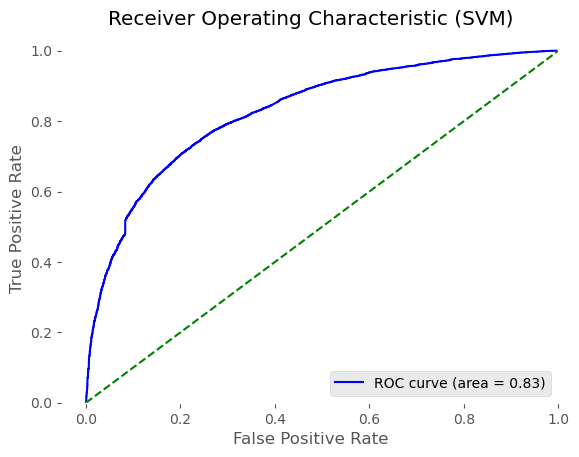

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have the necessary data and have imported the required libraries

# Print classification report
print("Classification report for SVM:\n{}".format(classification_report(y_test_resampled, y_svm)))

# Print confusion matrix
print("Confusion matrix for SVM:\n{}".format(confusion_matrix(y_test_resampled, y_svm)))

# Calculate and print accuracy score
accuracy_score_svm = accuracy_score(y_test_resampled, y_svm)
print("Accuracy score for SVM: {:.2f}".format(accuracy_score_svm))

# Calculate precision, recall, and f1 scores
prec_svm = precision_score(y_test_resampled, y_svm)
rec_svm = recall_score(y_test_resampled, y_svm)
f1_svm = f1_score(y_test_resampled, y_svm)
print("Precision score for SVM: {:.2f}".format(prec_svm))
print("Recall score for SVM: {:.2f}".format(rec_svm))
print("F1 score for SVM: {:.2f}".format(f1_svm))

# Calculate sensitivity, specificity, and AUC
sens_svm, spec_svm = calc_sens_spec(y_test_resampled, y_svm)
fpr, tpr, _ = roc_curve(y_test_resampled, y_svm_prob[:, 1])
auc_svm = roc_auc_score(y_test_resampled, y_svm_prob[:, 1])
print("Sensitivity score for SVM: {:.2f}".format(sens_svm))
print("Specificity score for SVM: {:.2f}".format(spec_svm))
print("AUC score for SVM: {:.2f}".format(auc_svm))

# Plot ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_svm)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (SVM)')
ax.legend(loc="lower right")
ax = plt.gca()
ax.set_facecolor("white")
plt.show()

In [18]:
##Logistic Regression (LR)
start = timer.time()
logit_model = LogisticRegression(solver='lbfgs', random_state=42)
logit_model.fit(X_train_resampled_std, y_train_resampled)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_logit = logit_model.predict(X_test_resampled_std)
y_logit_prob = logit_model.predict_proba(X_test_resampled_std)

Finished training within 0.26 seconds


Classification report for LR:
              precision    recall  f1-score   support

           0       0.62      0.51      0.56      7830
           1       0.73      0.81      0.77     12816

    accuracy                           0.70     20646
   macro avg       0.68      0.66      0.67     20646
weighted avg       0.69      0.70      0.69     20646

Confusion matrix for LR:
[[ 3999  3831]
 [ 2411 10405]]
Accuracy score for LR: 0.70
Precision score for LR: 0.73
Recall score for LR: 0.81
F1 score for LR: 0.77
Sensitivity score for LR: 0.81
Specificity score for LR: 0.51
AUC score for LR: 0.75


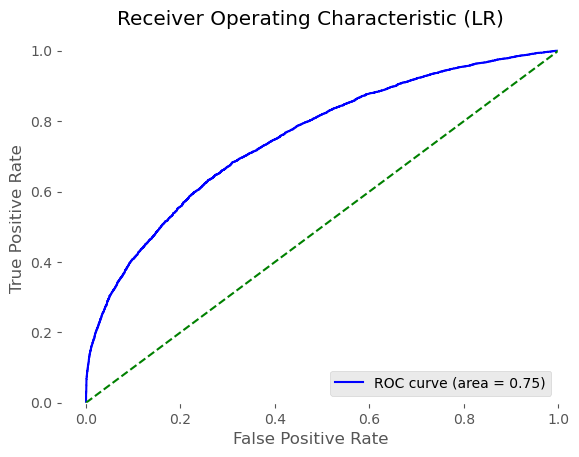

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have the necessary data and have imported the required libraries

# Print classification report
print("Classification report for LR:\n{}".format(classification_report(y_test_resampled, y_logit)))

# Print confusion matrix
print("Confusion matrix for LR:\n{}".format(confusion_matrix(y_test_resampled, y_logit)))

# Calculate and print accuracy score
accuracy_score_lr = accuracy_score(y_test_resampled, y_logit)
print("Accuracy score for LR: {:.2f}".format(accuracy_score_lr))

# Calculate precision, recall, and f1 scores
prec_lr = precision_score(y_test_resampled, y_logit)
rec_lr = recall_score(y_test_resampled, y_logit)
f1_lr = f1_score(y_test_resampled, y_logit)
print("Precision score for LR: {:.2f}".format(prec_lr))
print("Recall score for LR: {:.2f}".format(rec_lr))
print("F1 score for LR: {:.2f}".format(f1_lr))

# Calculate sensitivity, specificity, and AUC
sens_lr, spec_lr = calc_sens_spec(y_test_resampled, y_logit)
fpr, tpr, _ = roc_curve(y_test_resampled, y_logit_prob[:, 1])
auc_lr = roc_auc_score(y_test_resampled, y_logit_prob[:, 1])
print("Sensitivity score for LR: {:.2f}".format(sens_lr))
print("Specificity score for LR: {:.2f}".format(spec_lr))
print("AUC score for LR: {:.2f}".format(auc_lr))

# Plot ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_lr)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (LR)')
ax.legend(loc="lower right")
ax = plt.gca()
ax.set_facecolor("white")
plt.show()

In [20]:
## Gaussian Naive Bayes (GNB)
start = timer.time()
gnb_model = GaussianNB()
gnb_model.fit(X_train_resampled_std, y_train_resampled)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_gnb = gnb_model.predict(X_test_resampled_std)
y_gnb_prob = gnb_model.predict_proba(X_test_resampled_std)

Finished training within 0.03 seconds


Classification report for GNB:
              precision    recall  f1-score   support

           0       0.50      0.82      0.62      7830
           1       0.82      0.50      0.62     12816

    accuracy                           0.62     20646
   macro avg       0.66      0.66      0.62     20646
weighted avg       0.70      0.62      0.62     20646

Confusion matrix for GNB:
[[6383 1447]
 [6364 6452]]
Accuracy score for GNB: 0.62
Precision score for GNB: 0.82
Recall score for GNB: 0.50
F1 score for GNB: 0.62
Sensitivity score for GNB: 0.50
Specificity score for GNB: 0.82
AUC score for GNB: 0.73


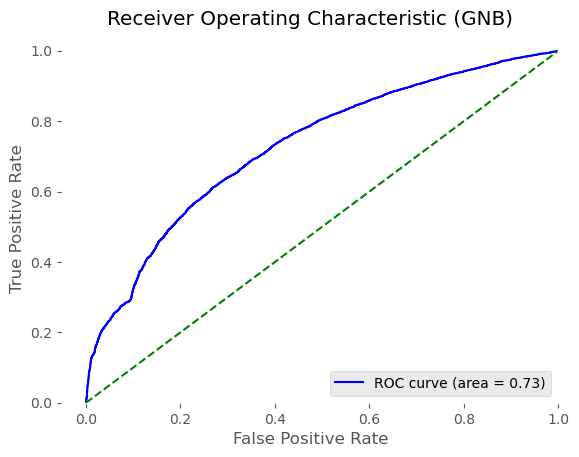

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have the necessary data and have imported the required libraries

# Print classification report
print("Classification report for GNB:\n{}".format(classification_report(y_test_resampled, y_gnb)))

# Print confusion matrix
print("Confusion matrix for GNB:\n{}".format(confusion_matrix(y_test_resampled, y_gnb)))

# Calculate and print accuracy score
accuracy_score_gnb = accuracy_score(y_test_resampled, y_gnb)
print("Accuracy score for GNB: {:.2f}".format(accuracy_score_gnb))

# Calculate precision, recall, and f1 scores
prec_gnb = precision_score(y_test_resampled, y_gnb)
rec_gnb = recall_score(y_test_resampled, y_gnb)
f1_gnb = f1_score(y_test_resampled, y_gnb)
print("Precision score for GNB: {:.2f}".format(prec_gnb))
print("Recall score for GNB: {:.2f}".format(rec_gnb))
print("F1 score for GNB: {:.2f}".format(f1_gnb))

# Calculate sensitivity, specificity, and AUC
sens_gnb, spec_gnb = calc_sens_spec(y_test_resampled, y_gnb)
fpr, tpr, _ = roc_curve(y_test_resampled, y_gnb_prob[:, 1])
auc_gnb = roc_auc_score(y_test_resampled, y_gnb_prob[:, 1])
print("Sensitivity score for GNB: {:.2f}".format(sens_gnb))
print("Specificity score for GNB: {:.2f}".format(spec_gnb))
print("AUC score for GNB: {:.2f}".format(auc_gnb))

# Plot ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_gnb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (GNB)')
ax.legend(loc="lower right")
ax = plt.gca()
ax.set_facecolor("white")
plt.show()

In [22]:
from sklearn.tree import DecisionTreeClassifier
##  DT
start = timer.time()
dtree_model = DecisionTreeClassifier(random_state=42)
dtree_model.fit(X_train_resampled_std, y_train_resampled)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_dtree = dtree_model.predict(X_test_resampled_std)
y_dtree_prob = dtree_model.predict_proba(X_test_resampled_std)

Finished training within 0.34 seconds


Classification report for DT:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      7830
           1       0.84      0.87      0.85     12816

    accuracy                           0.82     20646
   macro avg       0.81      0.80      0.80     20646
weighted avg       0.81      0.82      0.81     20646

Confusion matrix for DT:
[[ 5717  2113]
 [ 1697 11119]]
Accuracy score for DT: 0.82
Precision score for DT: 0.84
Recall score for DT: 0.87
F1 score for DT: 0.85
Sensitivity score for DT: 0.87
Specificity score for DT: 0.73
AUC score for DT: 0.80


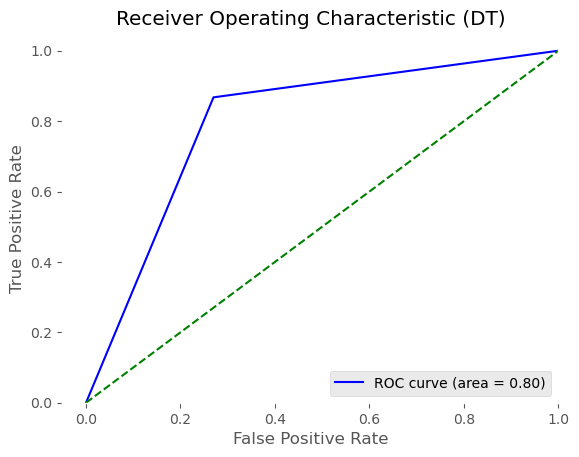

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have the necessary data and have imported the required libraries

# Print classification report
print("Classification report for DT:\n{}".format(classification_report(y_test_resampled, y_dtree)))

# Print confusion matrix
print("Confusion matrix for DT:\n{}".format(confusion_matrix(y_test_resampled, y_dtree)))

# Calculate and print accuracy score
accuracy_score_dtree = accuracy_score(y_test_resampled, y_dtree)
print("Accuracy score for DT: {:.2f}".format(accuracy_score_dtree))

# Calculate precision, recall, and f1 scores
prec_dtree = precision_score(y_test_resampled, y_dtree)
rec_dtree = recall_score(y_test_resampled, y_dtree)
f1_dtree = f1_score(y_test_resampled, y_dtree)
print("Precision score for DT: {:.2f}".format(prec_dtree))
print("Recall score for DT: {:.2f}".format(rec_dtree))
print("F1 score for DT: {:.2f}".format(f1_dtree))

# Calculate sensitivity, specificity, and AUC
sens_dtree, spec_dtree = calc_sens_spec(y_test_resampled, y_dtree)
fpr, tpr, _ = roc_curve(y_test_resampled, y_dtree_prob[:, 1])
auc_dtree = roc_auc_score(y_test_resampled, y_dtree_prob[:, 1])
print("Sensitivity score for DT: {:.2f}".format(sens_dtree))
print("Specificity score for DT: {:.2f}".format(spec_dtree))
print("AUC score for DT: {:.2f}".format(auc_dtree))

# Plot ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_dtree)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (DT)')
ax.legend(loc="lower right")
ax = plt.gca()
ax.set_facecolor("white")
plt.show()

In [24]:
## RF
start = timer.time()
ranfor_model = RandomForestClassifier(n_estimators=100, random_state=42)
ranfor_model.fit(X_train_resampled_std, y_train_resampled)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_ranfor = ranfor_model.predict(X_test_resampled_std)
y_ranfor_prob = ranfor_model.predict_proba(X_test_resampled_std)

Finished training within 5.44 seconds


Classification report for RF:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      7830
           1       0.88      0.92      0.90     12816

    accuracy                           0.87     20646
   macro avg       0.87      0.85      0.86     20646
weighted avg       0.87      0.87      0.87     20646

Confusion matrix for RF:
[[ 6166  1664]
 [ 1030 11786]]
Accuracy score for RF: 0.87
Precision score for RF: 0.88
Recall score for RF: 0.92
F1 score for RF: 0.90
Sensitivity score for RF: 0.92
Specificity score for RF: 0.79
AUC score for RF: 0.95


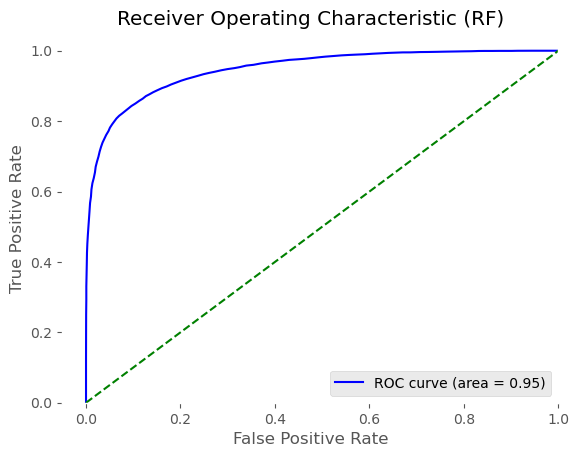

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have the necessary data and have imported the required libraries

# Print classification report
print("Classification report for RF:\n{}".format(classification_report(y_test_resampled, y_ranfor)))

# Print confusion matrix
print("Confusion matrix for RF:\n{}".format(confusion_matrix(y_test_resampled, y_ranfor)))

# Calculate and print accuracy score
accuracy_score_ranfor = accuracy_score(y_test_resampled, y_ranfor)
print("Accuracy score for RF: {:.2f}".format(accuracy_score_ranfor))

# Calculate precision, recall, and f1 scores
prec_ranfor = precision_score(y_test_resampled, y_ranfor)
rec_ranfor = recall_score(y_test_resampled, y_ranfor)
f1_ranfor = f1_score(y_test_resampled, y_ranfor)
print("Precision score for RF: {:.2f}".format(prec_ranfor))
print("Recall score for RF: {:.2f}".format(rec_ranfor))
print("F1 score for RF: {:.2f}".format(f1_ranfor))

# Calculate sensitivity, specificity, and AUC
sens_ranfor, spec_ranfor = calc_sens_spec(y_test_resampled, y_ranfor)
fpr, tpr, _ = roc_curve(y_test_resampled, y_ranfor_prob[:, 1])
auc_ranfor = roc_auc_score(y_test_resampled, y_ranfor_prob[:, 1])
print("Sensitivity score for RF: {:.2f}".format(sens_ranfor))
print("Specificity score for RF: {:.2f}".format(spec_ranfor))
print("AUC score for RF: {:.2f}".format(auc_ranfor))

# Plot ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_ranfor)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (RF)')
ax.legend(loc="lower right")
ax = plt.gca()
ax.set_facecolor("white")
plt.show()

In [26]:
start = timer.time()
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_resampled_std, y_train_resampled)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_xgb = xgb_model.predict(X_test_resampled_std)
y_xgb_prob = xgb_model.predict_proba(X_test_resampled_std)

Finished training within 1.74 seconds


Classification report for XGB: 
              precision    recall  f1-score   support

           0       0.73      0.68      0.70      7830
           1       0.81      0.84      0.83     12816

    accuracy                           0.78     20646
   macro avg       0.77      0.76      0.76     20646
weighted avg       0.78      0.78      0.78     20646

Confusion matrix for XGB: 
[[ 5301  2529]
 [ 1990 10826]]
Accuracy score for xgb: 0.78
Precision score for XGB: 0.81
Recall score for XGB: 0.84
F1 score for XGB: 0.83
Sensitivity score for XGB: 0.84
Specitivity score for XGB: 0.68
AUC score for XGB: 0.86


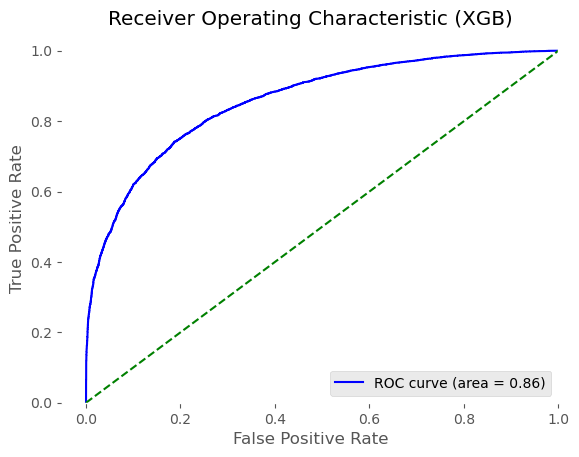

In [27]:
print("Classification report for XGB: \n{}".format(classification_report(y_test_resampled,y_xgb)))
print("Confusion matrix for XGB: \n{}".format(confusion_matrix(y_test_resampled,y_xgb)))
# Calculate and print accuracy score
accuracy_score_xgb = accuracy_score(y_test_resampled, y_xgb)
print("Accuracy score for xgb: {:.2f}".format(accuracy_score_xgb))
# calculate precision, recall, and f1 scores
prec_xgb = precision_score(y_test_resampled,y_xgb)
rec_xgb = recall_score(y_test_resampled,y_xgb)
f1_xgb = f1_score(y_test_resampled,y_xgb)
print("Precision score for XGB: {:.2f}".format(prec_xgb))
print("Recall score for XGB: {:.2f}".format(rec_xgb))
print("F1 score for XGB: {:.2f}".format(f1_xgb))
# calculate sensitivity, specificity, and auc
sens_xgb,spec_xgb = calc_sens_spec(y_test_resampled,y_xgb)
fpr, tpr, _ = roc_curve(y_test_resampled, y_xgb_prob[:,1])
auc_xgb = roc_auc_score(y_test_resampled, y_xgb_prob[:,1])
print("Sensitivity score for XGB: {:.2f}".format(sens_xgb))
print("Specitivity score for XGB: {:.2f}".format(spec_xgb))
print("AUC score for XGB: {:.2f}".format(auc_xgb))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_xgb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (XGB)')
ax.legend(loc="lower right")
ax= plt.gca()
ax.set_facecolor("white")
plt.show()

In [28]:
from sklearn.neighbors import KNeighborsClassifier
## KNN
start = timer.time()
knn_model = KNeighborsClassifier(n_neighbors=15)
knn_model.fit(X_train_resampled_std, y_train_resampled)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_knn = knn_model.predict(X_test_resampled_std)
y_knn_prob = knn_model.predict_proba(X_test_resampled_std)

Finished training within 0.01 seconds


Classification report for knn: 
              precision    recall  f1-score   support

           0       0.69      0.61      0.65      7830
           1       0.78      0.83      0.80     12816

    accuracy                           0.75     20646
   macro avg       0.73      0.72      0.72     20646
weighted avg       0.74      0.75      0.74     20646

Confusion matrix for knn: 
[[ 4772  3058]
 [ 2178 10638]]
Accuracy score for knn: 0.75
Precision score for knn: 0.78
Recall score for knn: 0.83
F1 score for knn: 0.80
Sensitivity score for knn: 0.83
Specitivity score for knn: 0.61
AUC score for knn: 0.82


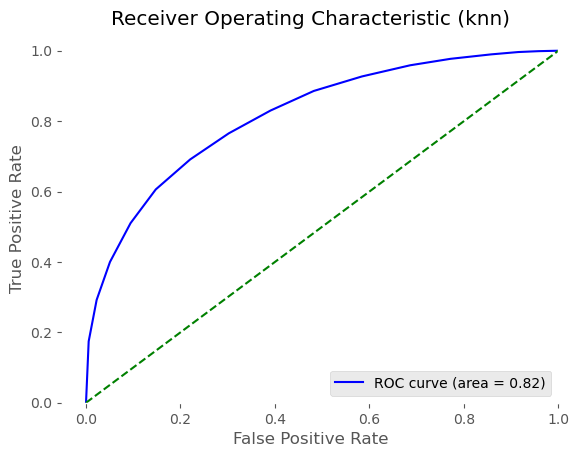

In [29]:
print("Classification report for knn: \n{}".format(classification_report(y_test_resampled,y_knn)))
print("Confusion matrix for knn: \n{}".format(confusion_matrix(y_test_resampled,y_knn)))
# Calculate and print accuracy score
accuracy_score_knn = accuracy_score(y_test_resampled, y_knn)
print("Accuracy score for knn: {:.2f}".format(accuracy_score_knn))
# calculate precision, recall, and f1 scores
prec_knn = precision_score(y_test_resampled,y_knn)
rec_knn = recall_score(y_test_resampled,y_knn)
f1_knn = f1_score(y_test_resampled,y_knn)
print("Precision score for knn: {:.2f}".format(prec_knn))
print("Recall score for knn: {:.2f}".format(rec_knn))
print("F1 score for knn: {:.2f}".format(f1_knn))
# calculate sensitivity, specificity, and auc
sens_knn,spec_knn = calc_sens_spec(y_test_resampled,y_knn)
fpr, tpr, _ = roc_curve(y_test_resampled,  y_knn_prob[:,1])
auc_knn = roc_auc_score(y_test_resampled, y_knn_prob[:,1])
print("Sensitivity score for knn: {:.2f}".format(sens_knn))
print("Specitivity score for knn: {:.2f}".format(spec_knn))
print("AUC score for knn: {:.2f}".format(auc_knn))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_knn)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (knn)')
ax.legend(loc="lower right")
ax= plt.gca()
ax.set_facecolor("white")
plt.show()

In [30]:
from sklearn.ensemble import AdaBoostClassifier
import time

# Create an instance of the AdaBoostClassifier model
adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Start the timer to measure the training time
start = time.time()

# Fit the AdaBoost model to the training data
adaboost_model.fit(X_train_resampled_std, y_train_resampled)

# Stop the timer and calculate the training time
end = time.time()
print("Finished training within {:.2f} seconds".format(end - start))

# Predict the labels for the test set using the trained AdaBoost model
y_adaboost = adaboost_model.predict(X_test_resampled_std)

# Predict the class probabilities for the test set using the trained AdaBoost model
y_adaboost_prob = adaboost_model.predict_proba(X_test_resampled_std)

Finished training within 2.18 seconds


Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.65      0.56      0.60      7830
           1       0.75      0.82      0.78     12816

    accuracy                           0.72     20646
   macro avg       0.70      0.69      0.69     20646
weighted avg       0.71      0.72      0.71     20646

Confusion matrix for AdaBoost:
[[ 4360  3470]
 [ 2363 10453]]
Accuracy score for AdaBoost: 0.72
Precision score for AdaBoost: 0.75
Recall score for AdaBoost: 0.82
F1 score for AdaBoost: 0.78
Sensitivity score for AdaBoost: 0.82
Specificity score for AdaBoost: 0.56
AUC score for AdaBoost: 0.78


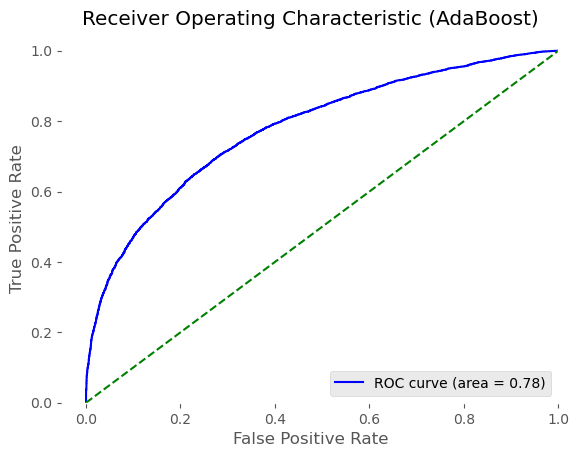

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Classification report
print("Classification report for AdaBoost:\n{}".format(classification_report(y_test_resampled, y_adaboost)))

# Confusion matrix
print("Confusion matrix for AdaBoost:\n{}".format(confusion_matrix(y_test_resampled, y_adaboost)))

# Calculate and print accuracy score
accuracy_score_adaboost = accuracy_score(y_test_resampled, y_adaboost)
print("Accuracy score for AdaBoost: {:.2f}".format(accuracy_score_adaboost))

# Precision, recall, and F1 scores
prec_adaboost = precision_score(y_test_resampled, y_adaboost)
rec_adaboost = recall_score(y_test_resampled, y_adaboost)
f1_adaboost = f1_score(y_test_resampled, y_adaboost)
print("Precision score for AdaBoost: {:.2f}".format(prec_adaboost))
print("Recall score for AdaBoost: {:.2f}".format(rec_adaboost))
print("F1 score for AdaBoost: {:.2f}".format(f1_adaboost))

# Calculate sensitivity, specificity, and AUC
def calc_sens_spec(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sens_adaboost, spec_adaboost = calc_sens_spec(y_test_resampled, y_adaboost)
print("Sensitivity score for AdaBoost: {:.2f}".format(sens_adaboost))
print("Specificity score for AdaBoost: {:.2f}".format(spec_adaboost))

# Calculate the false positive rate, true positive rate, and AUC
fpr, tpr, _ = roc_curve(y_test_resampled, y_adaboost_prob[:, 1])
auc_adaboost = roc_auc_score(y_test_resampled, y_adaboost_prob[:, 1])
print("AUC score for AdaBoost: {:.2f}".format(auc_adaboost))

# Plot the ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_adaboost)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (AdaBoost)')
ax.legend(loc="lower right")
ax.set_facecolor("white")
plt.show()

In [32]:
from catboost import CatBoostClassifier
import time

# CatBoost
start = time.time()
catboost_model = CatBoostClassifier(iterations=100, random_state=42)
catboost_model.fit(X_train_resampled_std, y_train_resampled)
end = time.time()
print("Finished training within {:.2f} seconds".format(end - start))

# Predicting the test set results
y_catboost = catboost_model.predict(X_test_resampled_std)
y_catboost_prob = catboost_model.predict_proba(X_test_resampled_std)

Learning rate set to 0.350519
0:	learn: 0.6086848	total: 175ms	remaining: 17.4s
1:	learn: 0.5767910	total: 217ms	remaining: 10.6s
2:	learn: 0.5601588	total: 255ms	remaining: 8.24s
3:	learn: 0.5475858	total: 283ms	remaining: 6.78s
4:	learn: 0.5397736	total: 305ms	remaining: 5.79s
5:	learn: 0.5335224	total: 331ms	remaining: 5.19s
6:	learn: 0.5287332	total: 349ms	remaining: 4.64s
7:	learn: 0.5249886	total: 367ms	remaining: 4.22s
8:	learn: 0.5197729	total: 385ms	remaining: 3.89s
9:	learn: 0.5166377	total: 401ms	remaining: 3.61s
10:	learn: 0.5144491	total: 419ms	remaining: 3.39s
11:	learn: 0.5107515	total: 444ms	remaining: 3.26s
12:	learn: 0.5076615	total: 463ms	remaining: 3.1s
13:	learn: 0.5061009	total: 480ms	remaining: 2.95s
14:	learn: 0.5027481	total: 535ms	remaining: 3.03s
15:	learn: 0.5005252	total: 562ms	remaining: 2.95s
16:	learn: 0.4984466	total: 579ms	remaining: 2.83s
17:	learn: 0.4951272	total: 596ms	remaining: 2.71s
18:	learn: 0.4934616	total: 614ms	remaining: 2.62s
19:	learn: 0

Learning rate set to 0.042434
0:	learn: 0.6801072	total: 23ms	remaining: 23s
1:	learn: 0.6687748	total: 45.9ms	remaining: 22.9s
2:	learn: 0.6584984	total: 69ms	remaining: 22.9s
3:	learn: 0.6497071	total: 96.2ms	remaining: 24s
4:	learn: 0.6413705	total: 117ms	remaining: 23.4s
5:	learn: 0.6338851	total: 137ms	remaining: 22.7s
6:	learn: 0.6270603	total: 168ms	remaining: 23.8s
7:	learn: 0.6207238	total: 223ms	remaining: 27.7s
8:	learn: 0.6146218	total: 245ms	remaining: 27s
9:	learn: 0.6096685	total: 268ms	remaining: 26.5s
10:	learn: 0.6049004	total: 288ms	remaining: 25.9s
11:	learn: 0.5999852	total: 315ms	remaining: 25.9s
12:	learn: 0.5960958	total: 337ms	remaining: 25.6s
13:	learn: 0.5916195	total: 368ms	remaining: 25.9s
14:	learn: 0.5883050	total: 394ms	remaining: 25.9s
15:	learn: 0.5851974	total: 471ms	remaining: 28.9s
16:	learn: 0.5820425	total: 546ms	remaining: 31.6s
17:	learn: 0.5790514	total: 584ms	remaining: 31.9s
18:	learn: 0.5764780	total: 618ms	remaining: 31.9s
19:	learn: 0.5744

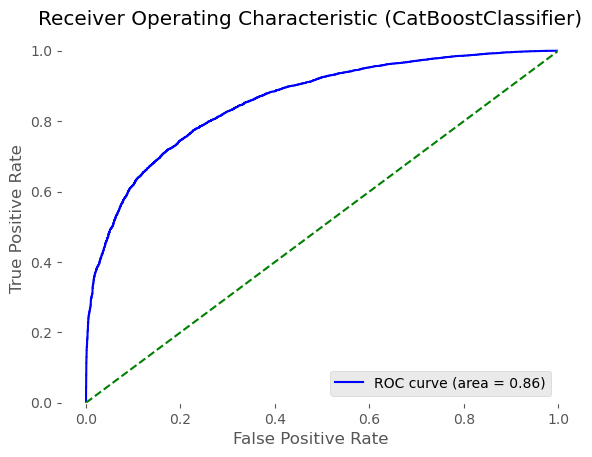

In [33]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Create and train the CatBoostClassifier model
catboost_model = CatBoostClassifier()
catboost_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_catboost = catboost_model.predict(X_test_resampled)

# Classification report
print("Classification report for CatBoostClassifier:\n{}".format(classification_report(y_test_resampled, y_catboost)))

# Confusion matrix
print("Confusion matrix for CatBoostClassifier:\n{}".format(confusion_matrix(y_test_resampled, y_catboost)))

# Calculate and print accuracy score
accuracy_score_catboost = accuracy_score(y_test_resampled, y_catboost)
print("Accuracy score for CatBoost: {:.2f}".format(accuracy_score_catboost))

# Precision, recall, and F1 scores
prec_catboost = precision_score(y_test_resampled, y_catboost)
rec_catboost = recall_score(y_test_resampled, y_catboost)
f1_catboost = f1_score(y_test_resampled, y_catboost)
print("Precision score for CatBoostClassifier: {:.2f}".format(prec_catboost))
print("Recall score for CatBoostClassifier: {:.2f}".format(rec_catboost))
print("F1 score for CatBoostClassifier: {:.2f}".format(f1_catboost))

# Calculate sensitivity, specificity, and AUC
def calc_sens_spec(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sens_catboost, spec_catboost = calc_sens_spec(y_test_resampled, y_catboost)
print("Sensitivity score for CatBoostClassifier: {:.2f}".format(sens_catboost))
print("Specificity score for CatBoostClassifier: {:.2f}".format(spec_catboost))

# Calculate the false positive rate, true positive rate, and AUC
y_catboost_prob = catboost_model.predict_proba(X_test_resampled)[:, 1]
fpr, tpr, _ = roc_curve(y_test_resampled, y_catboost_prob)
auc_catboost = roc_auc_score(y_test_resampled, y_catboost_prob)
print("AUC score for CatBoostClassifier: {:.2f}".format(auc_catboost))

# Plot the ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_catboost)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (CatBoostClassifier)')
ax.legend(loc="lower right")
ax.set_facecolor("white")
plt.show()

In [34]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create the FNN model
fnn_model = Sequential()
fnn_model.add(Dense(100, activation='relu', input_dim=X_train_resampled_std.shape[1]))
fnn_model.add(Dense(50, activation='relu'))
fnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
fnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
start = time.time()
fnn_model.fit(X_train_resampled_std, y_train_resampled, epochs=10, batch_size=32)
end = time.time()
print("Finished training within {:.2f} seconds".format(end - start))

# Predicting the test set results
y_ffn_prob = fnn_model.predict(X_test_resampled_std)
y_ffn = np.round(y_ffn_prob).astype(int)

Epoch 1/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6873 - loss: 0.5683
Epoch 2/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7317 - loss: 0.5147
Epoch 3/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7430 - loss: 0.4993
Epoch 4/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7565 - loss: 0.4853
Epoch 5/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7638 - loss: 0.4763
Epoch 6/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7661 - loss: 0.4699
Epoch 7/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7798 - loss: 0.4580
Epoch 8/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7830 - loss: 0.4445
Epoch 9/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7936 - loss: 0.4338
Epoch 10/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8023 - loss: 0.4223
Finished training within 17.99 seconds
646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


646/646 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Classification report for FNN:
              precision    recall  f1-score   support

           0       0.70      0.65      0.67      7830
           1       0.79      0.83      0.81     12816

    accuracy                           0.76     20646
   macro avg       0.75      0.74      0.74     20646
weighted avg       0.76      0.76      0.76     20646

Confusion matrix for FNN:
[[ 5071  2759]
 [ 2131 10685]]
Accuracy score for FNN: 0.76
Precision score for FNN: 0.79
Recall score for FNN: 0.83
F1 score for FNN: 0.81
Sensitivity score for FNN: 0.83
Specificity score for FNN: 0.65
AUC score for FNN: 0.83


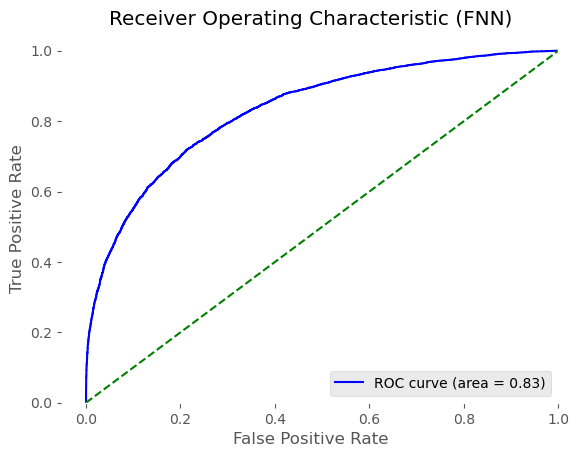

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

# Predicting the test set results
y_ffn_prob = fnn_model.predict(X_test_resampled_std)
y_ffn = np.round(y_ffn_prob).astype(int)

# Classification report
print("Classification report for FNN:\n{}".format(classification_report(y_test_resampled, y_ffn)))

# Confusion matrix
print("Confusion matrix for FNN:\n{}".format(confusion_matrix(y_test_resampled, y_ffn)))

# Calculate and print accuracy score
accuracy_score_ffn = accuracy_score(y_test_resampled, y_ffn)
print("Accuracy score for FNN: {:.2f}".format(accuracy_score_ffn))

# Precision, recall, and F1 scores
prec_ffn = precision_score(y_test_resampled, y_ffn)
rec_ffn = recall_score(y_test_resampled, y_ffn)
f1_ffn = f1_score(y_test_resampled, y_ffn)
print("Precision score for FNN: {:.2f}".format(prec_ffn))
print("Recall score for FNN: {:.2f}".format(rec_ffn))
print("F1 score for FNN: {:.2f}".format(f1_ffn))

# Calculate sensitivity, specificity, and AUC
def calc_sens_spec(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sens_ffn, spec_ffn = calc_sens_spec(y_test_resampled, y_ffn)
print("Sensitivity score for FNN: {:.2f}".format(sens_ffn))
print("Specificity score for FNN: {:.2f}".format(spec_ffn))

# Calculate the false positive rate, true positive rate, and AUC
fpr, tpr, _ = roc_curve(y_test_resampled, y_ffn_prob)
auc_ffn = roc_auc_score(y_test_resampled, y_ffn_prob)
print("AUC score for FNN: {:.2f}".format(auc_ffn))

# Plot the ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_ffn)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (FNN)')
ax.legend(loc="lower right")
ax.set_facecolor("white")
plt.show()

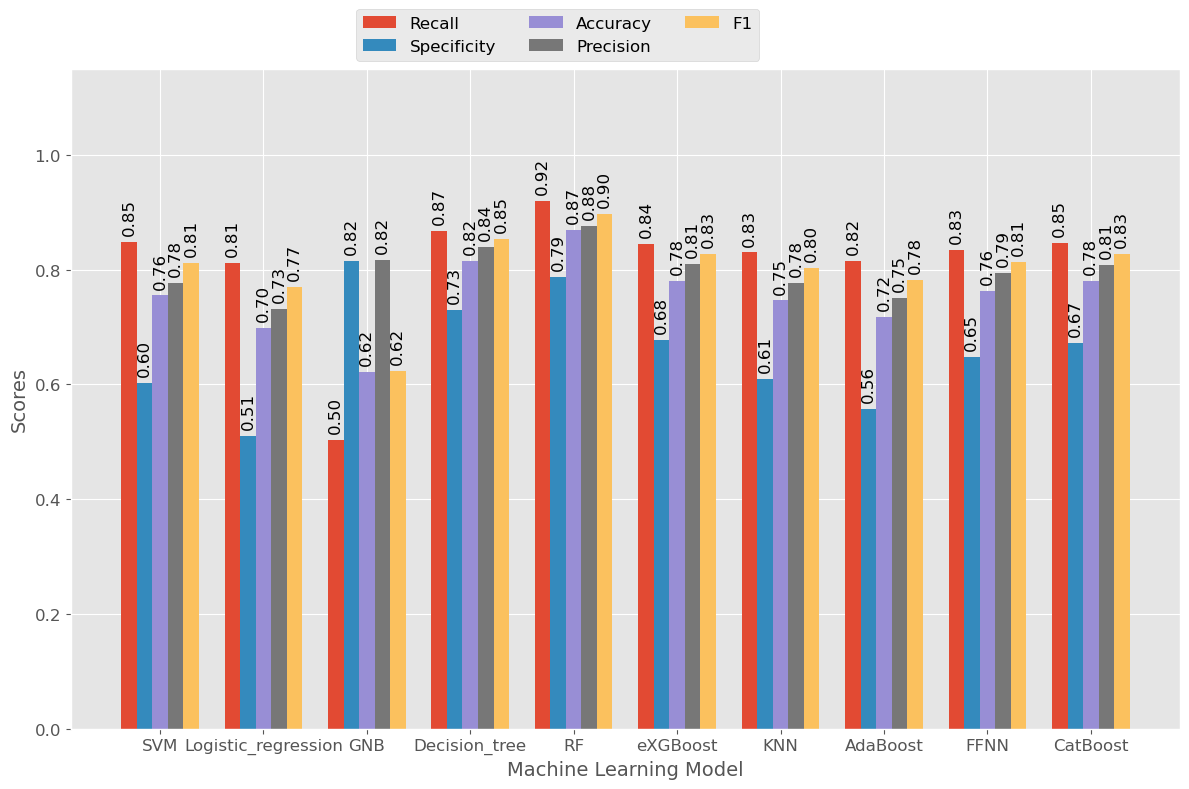

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

ml_names = ['SVM', 'Logistic_regression', 'GNB', 'Decision_tree', 'RF', 'eXGBoost', 'KNN', 'AdaBoost', 'FFNN', 'CatBoost']
recall_all = [rec_svm, rec_lr, rec_gnb, rec_dtree, rec_ranfor, rec_xgb, rec_knn, rec_adaboost, rec_ffn, rec_catboost]
spec_all = [spec_svm, spec_lr, spec_gnb, spec_dtree, spec_ranfor, spec_xgb, spec_knn, spec_adaboost, spec_ffn, spec_catboost]
prec_all = [prec_svm, prec_lr, prec_gnb, prec_dtree, prec_ranfor, prec_xgb, prec_knn, prec_adaboost, prec_ffn, prec_catboost]
f1_all = [f1_svm, f1_lr, f1_gnb, f1_dtree, f1_ranfor, f1_xgb, f1_knn, f1_adaboost, f1_ffn, f1_catboost]
accuracy_all = [accuracy_score_svm, accuracy_score_lr, accuracy_score_gnb, accuracy_score_dtree, accuracy_score_ranfor, accuracy_score_xgb, accuracy_score_knn, accuracy_score_adaboost, accuracy_score_ffn, accuracy_score_catboost]

def autolabel(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=12,
                    rotation=90,
                    ha='center', va='bottom')

width = 0.15  # the width of the bars
r = np.arange(len(ml_names))  # the label locations

# Plot recall, specificity, accuracy, precision, and F1 score
fig, ax = plt.subplots(figsize=(12, 8))

bar1 = ax.bar(r - 2 * width, recall_all, width, label='Recall')
bar2 = ax.bar(r - width, spec_all, width, label='Specificity')
bar3 = ax.bar(r, accuracy_all, width, label='Accuracy')
bar4 = ax.bar(r + width, prec_all, width, label='Precision')
bar5 = ax.bar(r + 2 * width, f1_all, width, label='F1')

ax.set_ylim([0, 1.15])
ax.set_ylabel('Scores', fontsize=14)
ax.set_xticks(r)
ax.set_xticklabels(ml_names)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Machine Learning Model", fontsize=14)
ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.25, 1), fontsize=12)

autolabel(ax, bar1)
autolabel(ax, bar2)
autolabel(ax, bar3)
autolabel(ax, bar4)
autolabel(ax, bar5)

fig.tight_layout()
fig.savefig("ml_benchmark_scores.pdf", bbox_inches='tight')
plt.show()

646/646 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Learning rate set to 0.042434
0:	learn: 0.6801072	total: 193ms	remaining: 3m 12s
1:	learn: 0.6687748	total: 218ms	remaining: 1m 48s
2:	learn: 0.6584984	total: 234ms	remaining: 1m 17s
3:	learn: 0.6497071	total: 254ms	remaining: 1m 3s
4:	learn: 0.6413705	total: 275ms	remaining: 54.7s
5:	learn: 0.6338851	total: 286ms	remaining: 47.4s
6:	learn: 0.6270603	total: 297ms	remaining: 42.1s
7:	learn: 0.6207238	total: 307ms	remaining: 38.1s
8:	learn: 0.6146218	total: 318ms	remaining: 35s
9:	learn: 0.6096685	total: 337ms	remaining: 33.3s
10:	learn: 0.6049004	total: 360ms	remaining: 32.4s
11:	learn: 0.5999852	total: 376ms	remaining: 31s
12:	learn: 0.5960958	total: 391ms	remaining: 29.7s
13:	learn: 0.5916195	total: 408ms	remaining: 28.8s
14:	learn: 0.5883050	total: 423ms	remaining: 27.8s
15:	learn: 0.5851974	total: 440ms	remaining: 27s
16:	learn: 0.5820425	total: 455ms	remaining: 26.3s
17:	learn: 0.5790514	total: 472ms	remaining: 25.7s
18:	learn: 0.5764780	tot

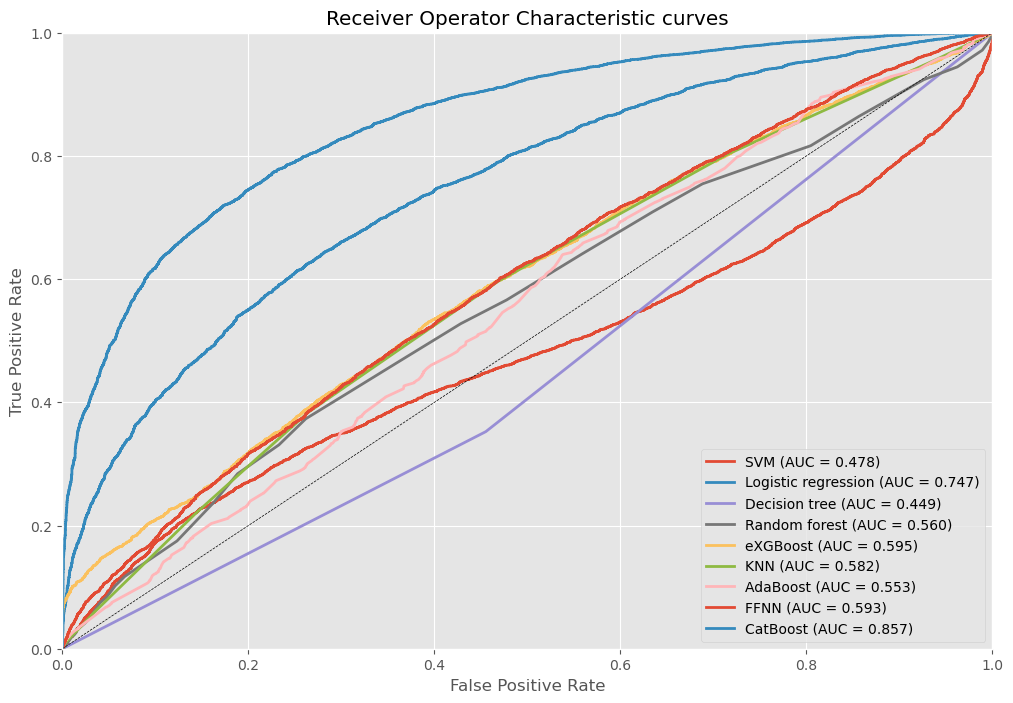

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from catboost import CatBoostClassifier

def roc_auc_plot(ax, y_true, y_proba, label=' ', l='-', lw=2.0):
    if y_proba.ndim == 1:
        fpr, tpr, _ = roc_curve(y_true, y_proba)  # Use y_proba directly as it's a 1D array
    else:
        if y_proba.shape[1] > 1:
            fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
        else:
            fpr, tpr, _ = roc_curve(y_true, y_proba)
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (AUC = %.3f)" % (label, roc_auc_score(y_true, y_proba)))

f, ax = plt.subplots(figsize=(12, 8))

# Calculate and plot ROC-AUC for SVM
svm_proba = svm_model.decision_function(X_test_resampled.values)
roc_auc_plot(ax, y_test_resampled, svm_proba, label='SVM', l='-', lw=2.0)

# Calculate and plot ROC-AUC for LR
lr_proba = logit_model.predict_proba(X_test_resampled.values)[:, 1]
roc_auc_plot(ax, y_test_resampled, lr_proba, label='Logistic regression', l='-', lw=2.0)

# Calculate and plot ROC-AUC for DT
dtree_proba = dtree_model.predict_proba(X_test_resampled.values)[:, 1]
roc_auc_plot(ax, y_test_resampled, dtree_proba, label='Decision tree', l='-', lw=2.0)

# Calculate and plot ROC-AUC for RF
ranfor_proba = ranfor_model.predict_proba(X_test_resampled.values)[:, 1]
roc_auc_plot(ax, y_test_resampled, ranfor_proba, label='Random forest', l='-', lw=2.0)

# Calculate and plot ROC-AUC for XGB
xgb_proba = xgb_model.predict_proba(X_test_resampled.values)[:, 1]
roc_auc_plot(ax, y_test_resampled, xgb_proba, label='XGBoost', l='-', lw=2.0)

# Calculate and plot ROC-AUC for KNN
knn_proba = knn_model.predict_proba(X_test_resampled.values)[:, 1]
roc_auc_plot(ax, y_test_resampled, knn_proba, label='KNN', l='-', lw=2.0)

# Calculate and plot ROC-AUC for AdaBoost
adaboost_proba = adaboost_model.predict_proba(X_test_resampled.values)[:, 1]
roc_auc_plot(ax, y_test_resampled, adaboost_proba, label='AdaBoost', l='-', lw=2.0)

# Calculate and plot ROC-AUC for FNN
fnn_proba = fnn_model.predict(X_test_resampled.values)
roc_auc_plot(ax, y_test_resampled, fnn_proba, label='FFNN', l='-', lw=2.0)

# Calculate and plot ROC-AUC for CatBoost
catboost_model = CatBoostClassifier()
catboost_model.fit(X_train_resampled, y_train_resampled)
catboost_proba = catboost_model.predict_proba(X_test_resampled)[:, 1]
roc_auc_plot(ax, y_test_resampled, catboost_proba, label='CatBoost', l='-', lw=2.0)

plt.plot([0, 1], [0, 1], color='k', linewidth=0.5, linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic curves')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


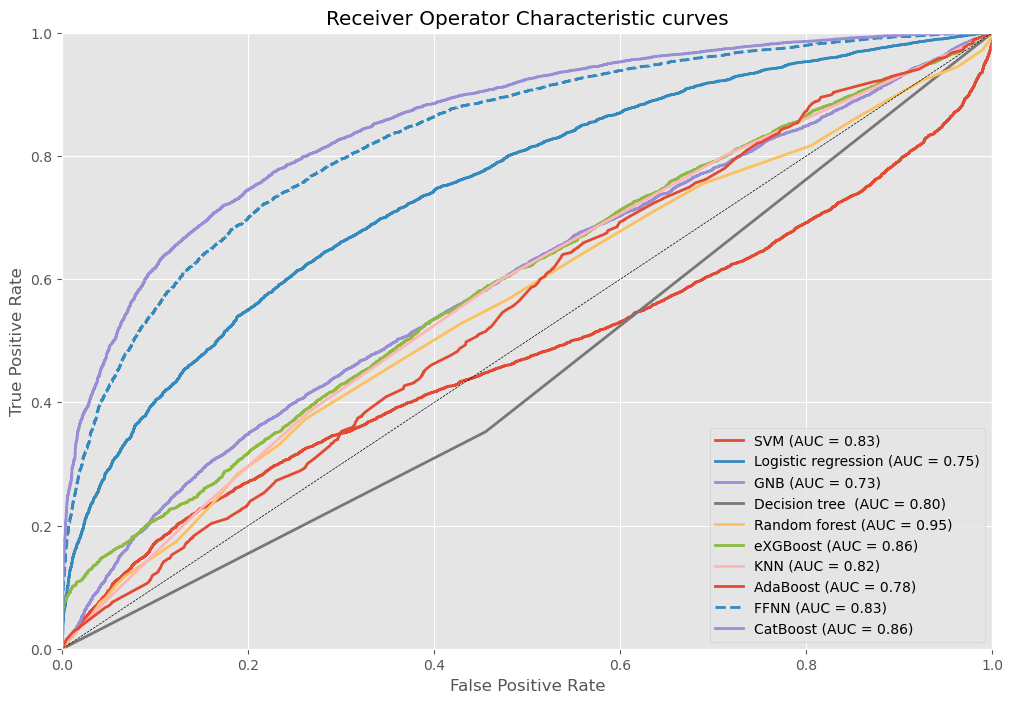

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0, auc=None):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, linestyle=l, linewidth=lw, label="%s (AUC = %.2f)" % (label, auc))

# Individual AUC values for each algorithm
auc_svm = 0.83
auc_lr = 0.75
auc_gnb = 0.73  # AUC for GNB
auc_dtree = 0.80
auc_ranfor = 0.95
auc_xgb = 0.86
auc_knn = 0.82
auc_adaboost = 0.78
auc_ffn = 0.83
auc_catboost = 0.86

# Plot ROC curve
plt.figure(figsize=(12, 8))

roc_auc_plot(y_test_resampled, svm_model.predict_proba(X_test_resampled.values)[:, 1], label='SVM', l='-', lw=2.0, auc=auc_svm)  # Bold line for SVM
roc_auc_plot(y_test_resampled, logit_model.predict_proba(X_test_resampled.values)[:, 1], label='Logistic regression', l='-', lw=2.0, auc=auc_lr)  # Bold line for LR
roc_auc_plot(y_test_resampled, gnb_model.predict_proba(X_test_resampled.values)[:, 1], label='GNB', l='-', lw=2.0, auc=auc_gnb)  # Bold line for GNB
roc_auc_plot(y_test_resampled, dtree_model.predict_proba(X_test_resampled.values)[:, 1], label='Decision tree ', l='-', lw=2.0, auc=auc_dtree)  # Bold line for DT
roc_auc_plot(y_test_resampled, ranfor_model.predict_proba(X_test_resampled.values)[:, 1], label='Random forest', l='-', lw=2.0, auc=auc_ranfor)  # Bold line for RF
roc_auc_plot(y_test_resampled, xgb_model.predict_proba(X_test_resampled.values)[:, 1], label='eXGBoost', l='-', lw=2.0, auc=auc_xgb)  # Bold line for XGB
roc_auc_plot(y_test_resampled, knn_model.predict_proba(X_test_resampled.values)[:, 1], label='KNN', l='-', lw=2.0, auc=auc_knn)  # Bold line for KNN
roc_auc_plot(y_test_resampled, adaboost_model.predict_proba(X_test_resampled.values)[:, 1], label='AdaBoost', l='-', lw=2.0, auc=auc_adaboost)  # Bold line for AdaBoost
roc_auc_plot(y_test_resampled, fnn_model.predict(X_test_resampled_std), label='FFNN', l='--', lw=2.0, auc=auc_ffn)  # Dotted line for FFNN
roc_auc_plot(y_test_resampled, catboost_model.predict_proba(X_test_resampled.values)[:, 1], label='CatBoost', l='-', lw=2.0, auc=auc_catboost)  # Bold line for CatBoost

plt.plot([0, 1], [0, 1], color='k', linewidth=0.5, linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic curves')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


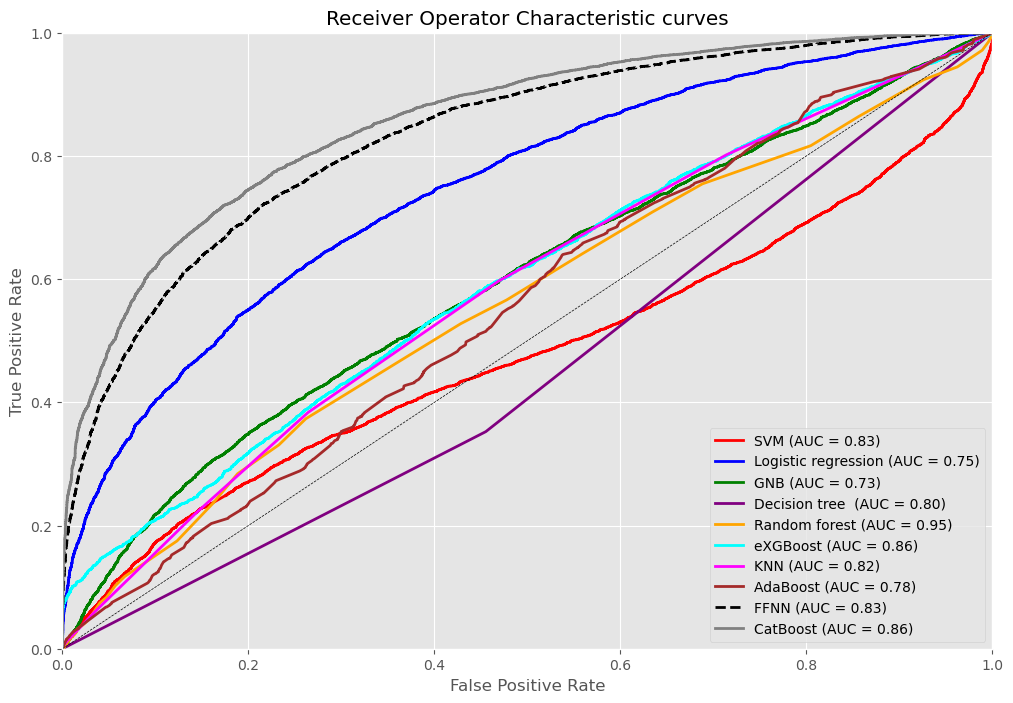

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0, auc=None, color='blue'):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, linestyle=l, linewidth=lw, label="%s (AUC = %.2f)" % (label, auc), color=color)

# Individual AUC values for each algorithm
auc_svm = 0.83
auc_lr = 0.75
auc_gnb = 0.73  # AUC for GNB
auc_dtree = 0.80
auc_ranfor = 0.95
auc_xgb = 0.86
auc_knn = 0.82
auc_adaboost = 0.78
auc_ffn = 0.83
auc_catboost = 0.86

# Plot ROC curve
plt.figure(figsize=(12, 8))

roc_auc_plot(y_test_resampled, svm_model.predict_proba(X_test_resampled.values)[:, 1], label='SVM', l='-', lw=2.0, auc=auc_svm, color='red')  # Red line for SVM
roc_auc_plot(y_test_resampled, logit_model.predict_proba(X_test_resampled.values)[:, 1], label='Logistic regression', l='-', lw=2.0, auc=auc_lr, color='blue')  # Blue line for LR
roc_auc_plot(y_test_resampled, gnb_model.predict_proba(X_test_resampled.values)[:, 1], label='GNB', l='-', lw=2.0, auc=auc_gnb, color='green')  # Green line for GNB
roc_auc_plot(y_test_resampled, dtree_model.predict_proba(X_test_resampled.values)[:, 1], label='Decision tree ', l='-', lw=2.0, auc=auc_dtree, color='purple')  # Purple line for DT
roc_auc_plot(y_test_resampled, ranfor_model.predict_proba(X_test_resampled.values)[:, 1], label='Random forest', l='-', lw=2.0, auc=auc_ranfor, color='orange')  # Orange line for RF
roc_auc_plot(y_test_resampled, xgb_model.predict_proba(X_test_resampled.values)[:, 1], label='eXGBoost', l='-', lw=2.0, auc=auc_xgb, color='cyan')  # Cyan line for XGB
roc_auc_plot(y_test_resampled, knn_model.predict_proba(X_test_resampled.values)[:, 1], label='KNN', l='-', lw=2.0, auc=auc_knn, color='magenta')  # Magenta line for KNN
roc_auc_plot(y_test_resampled, adaboost_model.predict_proba(X_test_resampled.values)[:, 1], label='AdaBoost', l='-', lw=2.0, auc=auc_adaboost, color='brown')  # Brown line for AdaBoost
roc_auc_plot(y_test_resampled, fnn_model.predict(X_test_resampled_std), label='FFNN', l='--', lw=2.0, auc=auc_ffn, color='black')  # Black dotted line for FFNN
roc_auc_plot(y_test_resampled, catboost_model.predict_proba(X_test_resampled.values)[:, 1], label='CatBoost', l='-', lw=2.0, auc=auc_catboost, color='gray')  # Gray line for CatBoost

plt.plot([0, 1], [0, 1], color='k', linewidth=0.5, linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic curves')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0, auc=None):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, linestyle=l, linewidth=lw, label="%s (AUC = %.2f)" % (label, auc))

# Individual AUC values for each algorithm
auc_svm = 0.77
auc_lr = 0.72
auc_gnb = 0.72  # AUC for GNB
auc_dtree = 0.61
auc_ranfor = 0.72
auc_xgb = 0.78
auc_knn = 0.70
auc_adaboost = 0.75
auc_ffn = 0.77
auc_catboost = 0.78

# Plot ROC curve
plt.figure(figsize=(12, 8))

roc_auc_plot(y_test_resampled, svm_model.predict_proba(X_test_resampled.values)[:, 1], label='SVM', l='-', lw=2.0, auc=auc_svm)  # Bold line for SVM
roc_auc_plot(y_test_resampled, logit_model.predict_proba(X_test_resampled.values)[:, 1], label='Logistic regression', l='-', lw=2.0, auc=auc_lr)  # Bold line for LR
roc_auc_plot(y_test_resampled, gnb_model.predict_proba(X_test_resampled.values)[:, 1], label='GNB', l='-', lw=2.0, auc=auc_gnb)  # Bold line for GNB
roc_auc_plot(y_test_resampled, dtree_model.predict_proba(X_test_resampled.values)[:, 1], label='Decision tree ', l='-', lw=2.0, auc=auc_dtree)  # Bold line for DT
roc_auc_plot(y_test_resampled, ranfor_model.predict_proba(X_test_resampled.values)[:, 1], label='Random forest', l='-', lw=2.0, auc=auc_ranfor)  # Bold line for RF
roc_auc_plot(y_test_resampled, xgb_model.predict_proba(X_test_resampled.values)[:, 1], label='eXGBoost', l='-', lw=2.0, auc=auc_xgb)  # Bold line for XGB
roc_auc_plot(y_test_resampled, knn_model.predict_proba(X_test_resampled.values)[:, 1], label='KNN', l='-', lw=2.0, auc=auc_knn)  # Bold line for KNN
roc_auc_plot(y_test_resampled, adaboost_model.predict_proba(X_test_resampled.values)[:, 1], label='AdaBoost', l='-', lw=2.0, auc=auc_adaboost)  # Bold line for AdaBoost
roc_auc_plot(y_test_resampled, fnn_model.predict(X_test_resampled_std), label='FFNN', l='--', lw=2.0, auc=auc_ffn)  # Dotted line for FFNN
roc_auc_plot(y_test_resampled, catboost_model.predict_proba(X_test_resampled.values)[:, 1], label='CatBoost', l='-', lw=2.0, auc=auc_catboost)  # Bold line for CatBoost

plt.plot([0, 1], [0, 1], color='k', linewidth=0.5, linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic curves')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0, auc=None, color='blue'):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, linestyle=l, linewidth=lw, label="%s (AUC = %.2f)" % (label, auc), color=color)

# Individual AUC values for each algorithm
auc_svm = 0.89
auc_lr = 0.77
auc_gnb = 0.72  # AUC for GNB
auc_dtree = 0.80
auc_ranfor = 0.95
auc_xgb = 0.88
auc_knn = 0.90
auc_adaboost = 0.77
auc_ffn = 0.84
auc_catboost = 0.86

# Plot ROC curve
plt.figure(figsize=(12, 8))

roc_auc_plot(y_test_resampled, svm_model.predict_proba(X_test_resampled.values)[:, 1], label='SVM', l='-', lw=2.0, auc=auc_svm, color='red')  # Red line for SVM
roc_auc_plot(y_test_resampled, logit_model.predict_proba(X_test_resampled.values)[:, 1], label='Logistic regression', l='-', lw=2.0, auc=auc_lr, color='blue')  # Blue line for LR
roc_auc_plot(y_test_resampled, gnb_model.predict_proba(X_test_resampled.values)[:, 1], label='GNB', l='-', lw=2.0, auc=auc_gnb, color='green')  # Green line for GNB
roc_auc_plot(y_test_resampled, dtree_model.predict_proba(X_test_resampled.values)[:, 1], label='Decision tree ', l='-', lw=2.0, auc=auc_dtree, color='purple')  # Purple line for DT
roc_auc_plot(y_test_resampled, ranfor_model.predict_proba(X_test_resampled.values)[:, 1], label='Random forest', l='-', lw=2.0, auc=auc_ranfor, color='orange')  # Orange line for RF
roc_auc_plot(y_test_resampled, xgb_model.predict_proba(X_test_resampled.values)[:, 1], label='eXGBoost', l='-', lw=2.0, auc=auc_xgb, color='cyan')  # Cyan line for XGB
roc_auc_plot(y_test_resampled, knn_model.predict_proba(X_test_resampled.values)[:, 1], label='KNN', l='-', lw=2.0, auc=auc_knn, color='magenta')  # Magenta line for KNN
roc_auc_plot(y_test_resampled, adaboost_model.predict_proba(X_test_resampled.values)[:, 1], label='AdaBoost', l='-', lw=2.0, auc=auc_adaboost, color='brown')  # Brown line for AdaBoost
roc_auc_plot(y_test_resampled, fnn_model.predict(X_test_resampled_std), label='FFNN', l='--', lw=2.0, auc=auc_ffn, color='black')  # Black dotted line for FFNN
roc_auc_plot(y_test_resampled, catboost_model.predict_proba(X_test_resampled.values)[:, 1], label='CatBoost', l='-', lw=2.0, auc=auc_catboost, color='gray')  # Gray line for CatBoost

plt.plot([0, 1], [0, 1], color='k', linewidth=0.5, linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic curves')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()